# Dog Breed Classification using AWS Sagemaker

This Python Notebook implements the Image Classification using AWS SageMaker with a pre-trained model.

The following tasks are performed.
- A pretrained Resnet50 model from pytorch vision library is used in the project (https://pytorch.org/vision/master/generated/torchvision.models.resnet50.html)
- Finetune the model with hyperparameter tuning and Network Re-shaping
- Implement Profiling and Debugging with hooks
- Deploy the model and perform inference


In [2]:
# Install packages
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-843666956861


## Dataset
Udacity's Dog Classification Data set is used to complete the task

In [4]:
# Fetch and upload the data to AWS S3
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# Command to download and unzip data
!unzip dogImages.zip

--2022-03-18 09:36:28--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 3.5.162.150
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|3.5.162.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  10.3MB/s    in 66s     

2022-03-18 09:37:36 (16.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenp

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg  
   creating: dogImages/test/002.Afghan_hound/
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_ho

In [5]:
prefix ="dogImagesDataset"
input_path = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {input_path}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-843666956861/dogImagesDataset


## Hyperparameter Tuning
- The ResNet model represents the deep Residual Learning Framework to ease the training process.
- A pair of fully connected Neural Networks has been added on top of the pretrained model to perform the classification task with 133 output nodes.
- AdamW from torch.optm is used as an optimizer.
- The Following hyperparamets are used:
    - Learning rate-  0.01x to 100x
    - eps -  1e-09 to 1e-08
    - Weight decay -  0.1x to 10x
    - Batch size -  [ 64, 128 ]

The `hpo.py` script is used to perform hyperparameter tuning.

In [6]:
#Importing all the required modules fomr tuner
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer which uses a different( more correct or better) way to calulate the weight decay related computations
# So we will be using weight_decay and eps hyperparamter tuning as well , along with the lerning rate and batchsize params
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [8]:
tuner.fit({"training": input_path }, wait=True)
print(f"Tunning process completed")

................................................................................................................................................................................!
Tunning process completed


In [9]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-03-18 10:06:31 Starting - Preparing the instances for training
2022-03-18 10:06:31 Downloading - Downloading input data
2022-03-18 10:06:31 Training - Training image download completed. Training in progress.
2022-03-18 10:06:31 Uploading - Uploading generated training model
2022-03-18 10:06:31 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '8.925835486782652e-09',
 'lr': '0.0002762341319592882',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2022-03-18-09-54-06-434"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-843666956861/dog-breed-classification-hpo-2022-03-18-09-54-06-434/source/sourcedir.tar.gz"',
 'weight_decay': '0.02953844241366778'}

In [10]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 128, 'eps': '8.925835486782652e-09', 'lr': '0.0002762341319592882', 'weight_decay': '0.02953844241366778'}


## Model Profiling and Debugging
The hyperparameters obtained above is used to finetune the model

The `train_model.py` script is used to perform model profiling and debugging.

In [11]:
# Setting up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [59]:
# Create and fit an estimator


estimator = PyTorch(entry_point='train_model.py',
                    role=role,
                    py_version='py3',
                    framework_version='1.6',
                    instance_count=2,
                    instance_type='ml.p2.xlarge',
                    profiler_config=profiler_config, # include the profiler hook
                    debugger_hook_config=debugger_config, # include the debugger hook
                    # rules=rules,
                    hyperparameters = ({'batch_size': 128, 'eps': '8.925835486782652e-09', 'lr': '0.0002762341319592882', 'weight_decay': '0.02953844241366778'})
                   )


estimator.fit(wait=True)

2022-03-18 13:39:56 Starting - Starting the training job...ProfilerReport-1647610796: InProgress
...
2022-03-18 13:40:41 Starting - Preparing the instances for training.........
2022-03-18 13:42:21 Downloading - Downloading input data...
2022-03-18 13:42:55 Training - Downloading the training image..................
2022-03-18 13:45:47 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-18 13:45:50,957 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-18 13:45:50,989 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-18 13:45:51,004 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-18 13:45:51,510 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_i

UnexpectedStatusException: Error for Training job pytorch-training-2022-03-18-13-39-56-383: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 train_model.py --batch_size 128 --eps 8.925835486782652e-09 --lr 0.0002762341319592882 --weight_decay 0.02953844241366778"
Traceback (most recent call last):
  File "train_model.py", line 208, in <module>
    parser.add_argument('--data', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
  File "/opt/conda/lib/python3.6/os.py", line 669, in __getitem__
    raise KeyError(key) from None
KeyError: 'SM_CHANNEL_TRAINING', exit code: 1

In [25]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2021-12-22-15-55-02-949
Client: <botocore.client.SageMaker object at 0x7f81d4299438>
Description: {'TrainingJobName': 'pytorch-training-2021-12-22-15-55-02-949', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:564531353785:training-job/pytorch-training-2021-12-22-15-55-02-949', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-564531353785/pytorch-training-2021-12-22-15-55-02-949/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'eps': '"7.618255765956927e-09"', 'lr': '"0.0005369012968801728"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2021-12-22-15-55-02-949"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-564531353785/pytorch-training-2021-12-22-15-55-02-949/source/sourcedir.tar.gz"', 'weight_decay': '"0.002032662137104155"'}, 'AlgorithmSpecifi

In [27]:
# Define a Trail

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2021-12-22 16:06:52.353 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-4bc1f3597a3fd3d3d1e8cfe2e695:44 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-22 16:06:52.369 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-4bc1f3597a3fd3d3d1e8cfe2e695:44 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-564531353785/pytorch-training-2021-12-22-15-55-02-949/debug-output


[2021-12-22 16:07:01.521 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-4bc1f3597a3fd3d3d1e8cfe2e695:44 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-22 16:07:02.544 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-4bc1f3597a3fd3d3d1e8cfe2e695:44 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


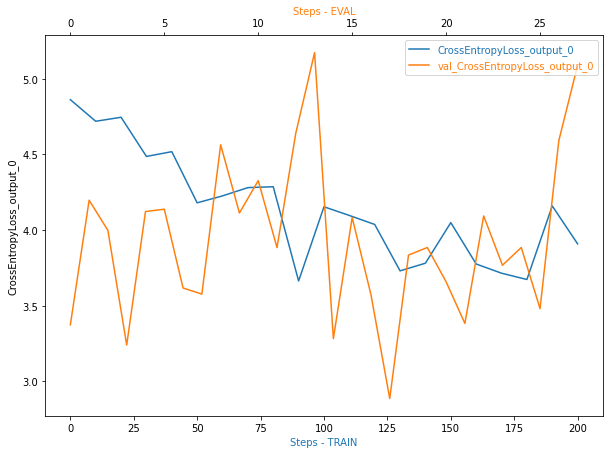

In [28]:
# TODO: Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?
- There is no smooth output line and there are different highs and lows for the batch sets.
If not, suppose there was an error. What would that error look like and how would you have fixed it?
- A proper mix of the batches with shuffling could help the model learn better
- trying out different neural network architecture.

In [29]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-564531353785/pytorch-training-2021-12-22-15-55-02-949/rule-output


In [30]:
! aws s3 ls {rule_output_path} --recursive

2021-12-22 16:05:07     380924 pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-22 16:05:07     230113 pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-22 16:05:02        191 pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-22 16:05:02      13571 pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-22 16:05:02        126 pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-22 16:05:02        129 pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-22 16:05:02       4107 pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-re

In [31]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-564531353785/pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-564531353785/pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-564531353785/pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-564531353785/pytorch-training-2021-12-22-15-55-02-949/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-564531353785/py

In [32]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [33]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [34]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_repot.zip", "zip", "ProfilerReport")

'/root/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_repot.zip.zip'

## Model Deploying

In [35]:
# Deploy your model to an endpoint

predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

INFO:sagemaker:Creating model with name: pytorch-training-2021-12-22-16-10-19-406
INFO:sagemaker:Creating endpoint with name pytorch-training-2021-12-22-16-10-19-406


------!

In [50]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-564531353785/pytorch-training-2021-12-22-15-55-02-949/output/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")

INFO:sagemaker:Creating model with name: pytorch-inference-2021-12-22-17-04-53-334
INFO:sagemaker:Creating endpoint with name pytorch-inference-2021-12-22-17-04-53-638


--------------!

Test image no: 1
Below is the image that we will be testing:


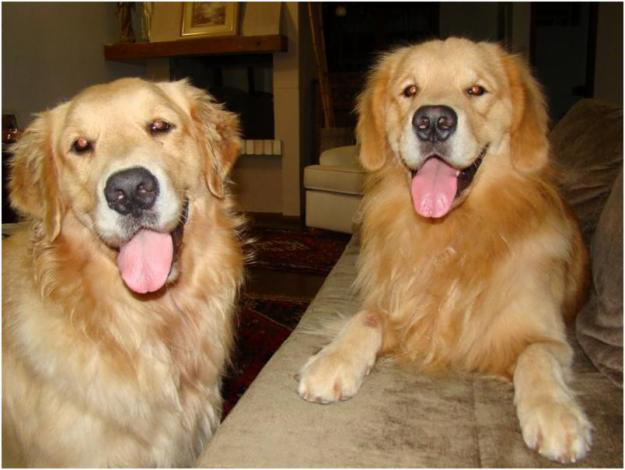

Expected dog breed category no : 76
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5561081171035767, 0.015956562012434006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08113594353199005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9516431093215942, 0.41486212611198425, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6348479986190796, 0.0, 2.640993595123291, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.617493748664856, 0.0, 0.0, 0.0, 0.0, 4.381164073944092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2218393236398697, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [112]
Test image no: 2
Below is the image that we will be testing:


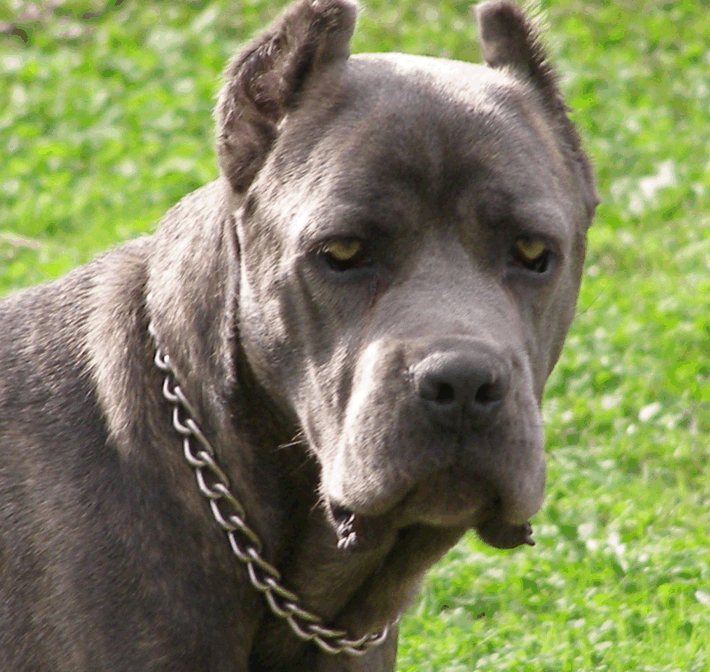

Expected dog breed category no : 44
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9791253209114075, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.035891342908144, 0.0, 0.004853527992963791, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0078399181365967, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.564339280128479, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21555417776107788, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9512609243392944, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2609694004058838, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [41]
Test image no: 3
Below is the image that we will be testing:


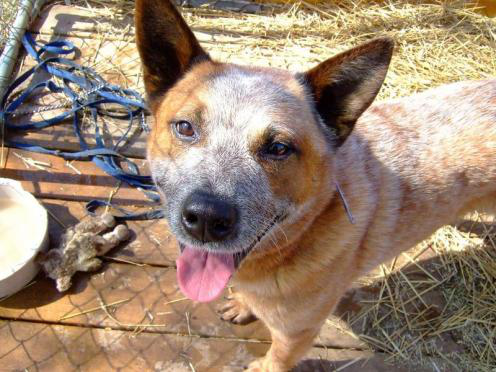

Expected dog breed category no : 11
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.437103033065796, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4203791618347168, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9209169149398804, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05539356917142868, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [20]


In [51]:
#Testing the deployed endpoint using some test images
#Solution 1: Using the Predictor object directly.
from PIL import Image
import io
import os
import numpy as np

test_dir = "./testImages"
test_images = [ "TestImg_Golden_retriever.jpg", 'TestImg_Cane_corso.jpg', 'TestImg_Australian_cattle_dog.jpg' ]
test_images_expected_output = [76, 44, 11]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [52]:
print(predictor.endpoint_name)
endpoint_name = predictor.endpoint_name

pytorch-inference-2021-12-22-17-04-53-638


Test image no: 1
Below is the image that we will be testing:


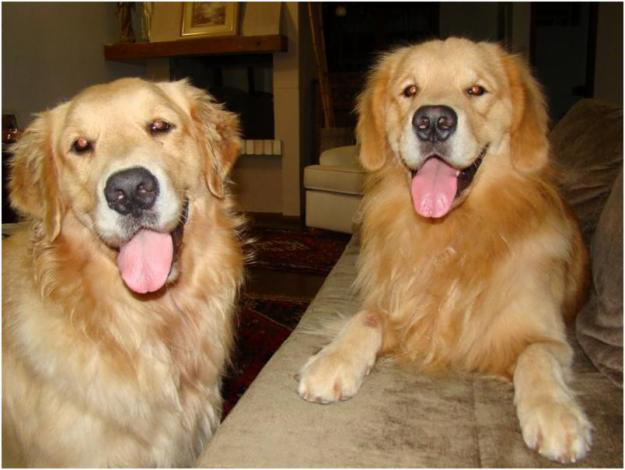

Expected dog breed category no : 76
Response: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.55610812 0.01595656 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.08113594 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         1.95164311
  0.41486213 0.         0.         0.         0.         0.
  0.         0.         0.         0.         

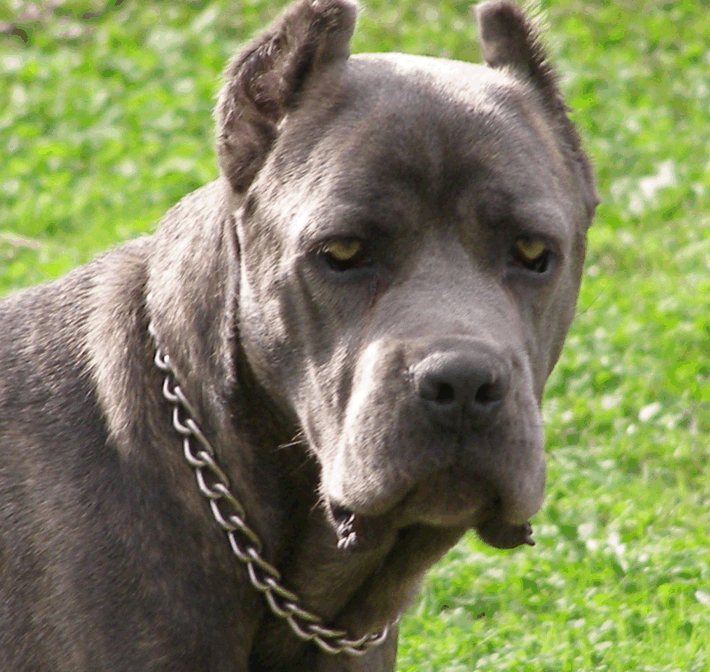

Expected dog breed category no : 44
Response: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.97912532 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.03589134 0.         0.00485353 0.         0.
  0.         0.         0.         0.         2.00783992 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.56433928
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.21555418
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0. 

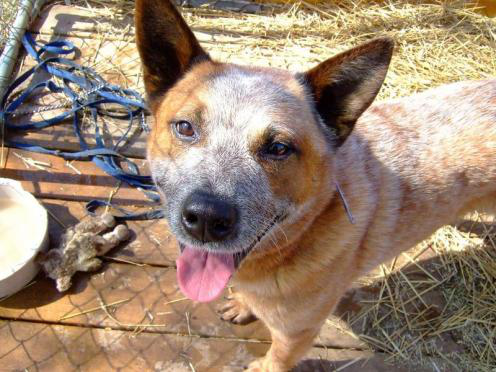

Expected dog breed category no : 11
Response: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         2.43710303 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.42037916 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.92091691
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         

In [54]:
# Solution 2: Using boto3
# Using the runtime boto3 client to test the deployed models endpoint
import os
import io
import boto3
import json
import base64
import PIL
# setting the  environment variables

ENDPOINT_NAME = endpoint_name
# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')
test_dir = "./testImages"
test_images = [ "TestImg_Golden_retriever.jpg", 'TestImg_Cane_corso.jpg', 'TestImg_Australian_cattle_dog.jpg' ]
test_images_expected_output = [76, 44, 11]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='image/jpeg',
                                       Body=payload)
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
        print(f"Response: {response_body}")        
        predicted_dog_breed = np.argmax(response_body,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [55]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2021-12-22-17-04-53-638
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2021-12-22-17-04-53-638
